In [1]:
import os
import tempfile
import pywcs
import shutil
import sys
import glob
import h5py
import pyfits
from pylab import arange, show, cm
import scipy.optimize as opt

import pandas as pd
import numpy as np
import healpy as hp

from astropy.io import fits
from astropy.wcs import WCS
from astropy import units as u
from astropy.coordinates import SkyCoord, Angle, FK5
import time
# from reproject import reproject_from_healpix


import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

# Third-party imports
import gcn
import gcn.handlers
import gcn.notice_types
import requests
import subprocess

%matplotlib inline

RuntimeError: module compiled against API version 0xc but this version of numpy is 0xa

/afhome/kuiack/newtrap/local/lib/python2.7/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


In [2]:
def get_skymap(root):
    """
    Look up URL of sky map in VOEvent XML document,
    download sky map, and parse FITS file.
    """
    # Read out URL of sky map.
    # This will be something like
    # https://gracedb.ligo.org/apibasic/events/M131141/files/bayestar.fits.gz
    skymap_url = root.find(
        "./What/Param[@name='SKYMAP_URL_FITS_BASIC']").attrib['value']

    # Send HTTP request for sky map
    response = requests.get(skymap_url, stream=True)

    # Uncomment to save VOEvent payload to file
    # open('example.xml', 'w').write(payload)

    # Raise an exception unless the download succeeded (HTTP 200 OK)
    response.raise_for_status()

    # Create a temporary file to store the downloaded FITS file
    with tempfile.NamedTemporaryFile() as tmpfile:
        # Save the FITS file to the temporary file
        shutil.copyfileobj(response.raw, tmpfile)
        tmpfile.flush()

        # Uncomment to save FITS payload to file
        # shutil.copyfileobj(reponse.raw, open('example.fits.gz', 'wb'))

        # Read HEALPix data from the temporary file
        skymap, header = hp.read_map(tmpfile.name, h=True, verbose=False)
        header = dict(header)

    # Done!
    return skymap, header

def max_probability(skymap):
    npix = len(skymap)
    nside = hp.npix2nside(npix)
    ipix_max = np.argmax(skymap)
    skymap[ipix_max]
    theta, phi = hp.pix2ang(nside, ipix_max)
    ra = np.rad2deg(phi)
    dec = np.rad2deg(0.5 * np.pi - theta)
    return ra, dec

def download_skymap(grace_id, name='bayestar', base_url='https://gracedb.ligo.org/apiweb/superevents'):
    """
    Download a sky map from GraceDb.

    Parameters
    ----------
    grace_id : string
        The GraceDb identifier of the event
    name : string
        The filename, less the '.fits.gz' extension
    base_url : string
        The base URL of the GraceDb server. By default, the production server.
    """

    command = 'curl --netrc {base_url}/{grace_id}/files/{name}.fits.gz -o {grace_id}_{name}.fits.gz'.format(
        base_url=base_url, grace_id=grace_id, name=name)
    print(command)
    os.system(command)


In [3]:
# grace_id = 'S190412m'        # identifier for the event
grace_id = 'S190518bb' 
download_skymap(grace_id)

curl --netrc https://gracedb.ligo.org/apiweb/superevents/S190518bb/files/bayestar.fits.gz -o S190518bb_bayestar.fits.gz


In [4]:
filename6 = 'S190518bb_bayestar.fits.gz'
_img6 = "/data/20190518/2019-05-18T18:58:56-S314-B7.fits"

filename5 = 'S190510g_bayestar.fits.gz'
_img5 = "/data/20190510/2019-05-10T02:59:39-S314-B7.fits"


filename4 = 'S190426c_bayestar.fits.gz'
_img4 = "/data/20190426/2019-04-26T11:17:56-S314-B8.fits"


filename3 = 'S190425z_bayestar.fits.gz'
_img3 = "/data/20190425/2019-04-25T09:20:00-S314-B8.fits"


filename2 = 'S190412m_bayestar.fits.gz'
_img2 = "/data/20190412/2019-04-12T05:31:03-S314-B8.fits"


filename1 = 'S190408an_bayestar.fits.gz'
_img1 = "/data/20190408/2019-04-08T18:18:02-S314-B8.fits"

In [10]:
_filename = filename4
_img = _img4

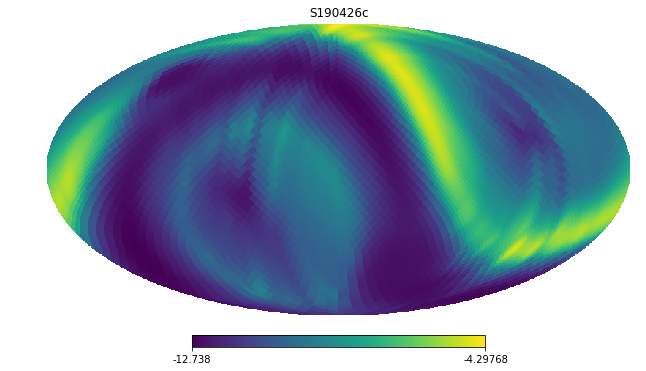

In [11]:
# filename = 'S190425z_bayestar.fits.gz'

skymap, header = hp.read_map(_filename, h=True, verbose=False)
hp.mollview(np.log10(skymap), title=_filename.split("_")[0],)

In [ ]:
filename = 'S190412m_bayestar.fits.gz'

skymap, header = hp.read_map(filename, h=True, verbose=False)
hp.mollview(np.log10(skymap), title=filename.split("_")[0],) 
# hp.graticule()

In [12]:
npix = len(skymap)
nside = hp.npix2nside(npix)


hp_index = np.arange(hp.nside2npix(nside))
mask = np.zeros(hp.nside2npix(nside))


for percentile in [0.9, 0.5, 0.1]:
    # Get index of element nearest to nth percentile 
    nth_element = np.argmin(np.abs(np.cumsum(skymap[np.argsort(skymap)[::-1]]) - percentile))
    # Add 1 to all elemets up to nth percentile 
    mask[np.argsort(skymap)[::-1][:nth_element]] += 1.0



0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


(6.2999999999999998, 85.430252940093638)

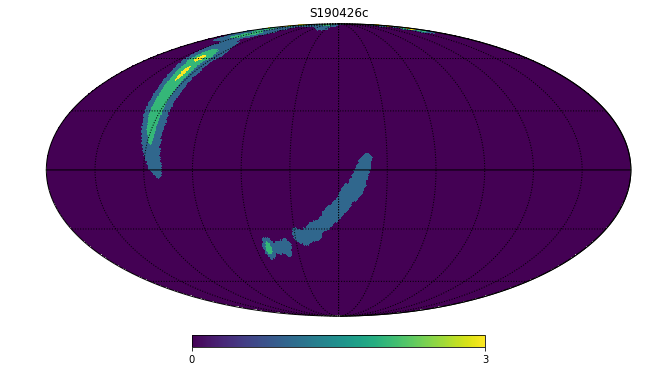

In [13]:

theta, phi = hp.pix2ang(nside, np.argmax(skymap))

# rotate towards max value 
# hp.mollview(mask, rot=(np.rad2deg(phi), np.rad2deg(0.5 * np.pi - theta), 0))
hp.mollview(mask, rot=(-180, 0, 0), flip="astro", title=_filename.split("_")[0])
hp.graticule()

max_probability(skymap)

In [14]:
# image pixel coordinate grids
meshx, meshy = np.meshgrid(np.linspace(0,1023,1024),np.linspace(0,1023,1024))

#  image WGC object 
image_wcs = WCS(_img)

# image data
tmp_img = np.array(fits.open(_img)[0].data[0,0,:,:],dtype=np.float)

# convert image pixel coordinate grid to sky coordinates 
ra, dec, notused, nnotused = image_wcs.wcs_pix2world(meshx,meshy,1,1,1)

# Get skymap value interpolated at image pixel/WCS coordinate grid 
# this step is slow, lots of wasted calculations
output = hp.get_interp_val(mask,np.deg2rad(np.ravel(90-dec)), np.deg2rad(np.ravel(ra)) ).reshape(1024,1024)


plt.figure(figsize=(10,10))
plt.imshow(tmp_img, vmin=-50, vmax=50, origin="lower", cmap="YlGnBu_r")

CS =  plt.contour(output, linewidth=3, levels=[0.1,1.1,2.1], colors=["orange","red","black"])

plt.title("{} \n {} UTC".format(_filename.split("_")[0], _img.split("/")[3][:19]))
plt.xticks([])
plt.yticks([])

labels = ['90%', '50%','10%']
for i in range(len(labels)):
    CS.collections[i].set_label(labels[i])

plt.legend(loc='upper left')

plt.show()

/data/20190426/2019-04-26T11:17:56-S314-B8.fits                                  [astropy.io.fits.card]


IOError: [Errno 2] No such file or directory: '/data/20190426/2019-04-26T11:17:56-S314-B8.fits'

In [ ]:


plt.figure(figsize=(10,10))
plt.imshow(tmp_img,vmin=-50, vmax=50, origin="lower", cmap="YlGnBu_r")

CS =  plt.contour(output, linewidth=3, levels=[0.1,1.1,2.1], colors=["orange","red","black"])


plt.title("S190425z \n 2019-04-25 09:20:00 UTC")
plt.xticks([])
plt.yticks([])

labels = ['90%', '50%','10%']
for i in range(len(labels)):
    CS.collections[i].set_label(labels[i])

plt.legend(loc='upper left')

plt.show()

<IPython.core.display.Javascript object>


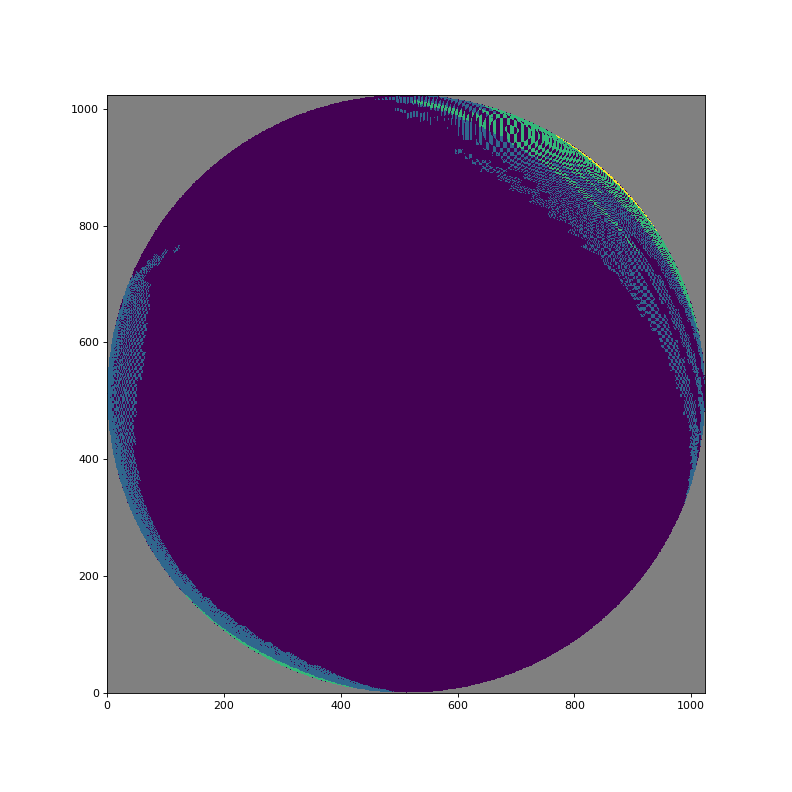

<IPython.core.display.Javascript object>


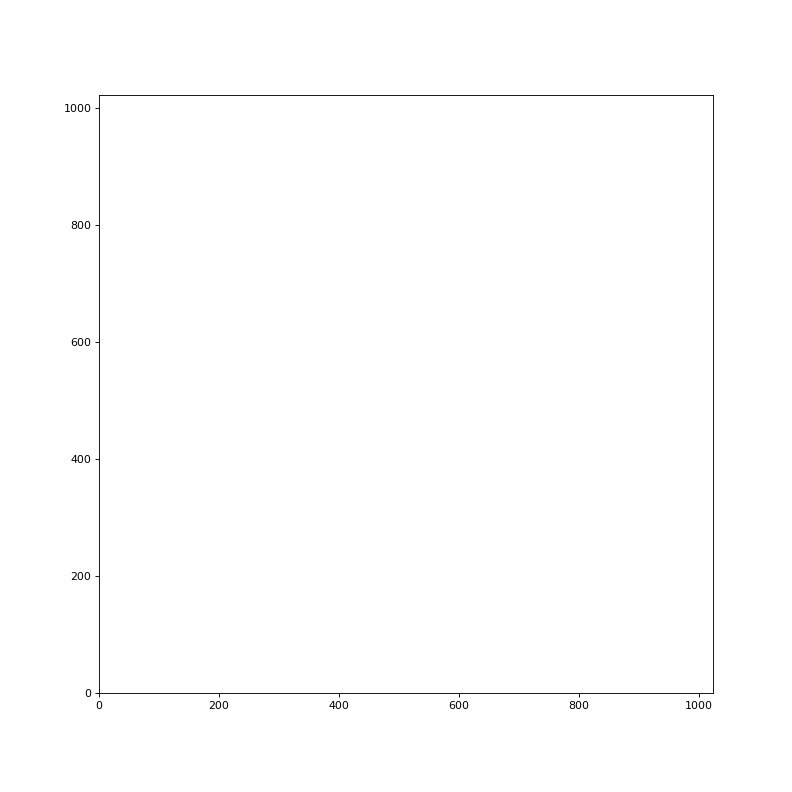

In [72]:
# img_contour_smooth = scipy.ndimage.zoom(img_contour, 30)
import scipy as sp
import scipy.ndimage
# Apply gaussian filter
sigma = [10, 10]
size = 2

img_contour_smooth = sp.ndimage.filters.uniform_filter(img_contour, size,cval=0, mode='constant')

plt.figure(figsize=(10,10))
plt.imshow(img_contour, origin="lower")
plt.figure(figsize=(10,10))
plt.contour(img_contour_smooth)

/afhome/kuiack/newtrap/lib/python2.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()


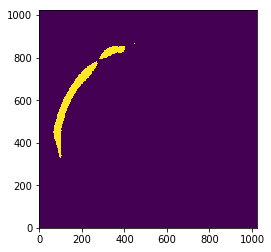

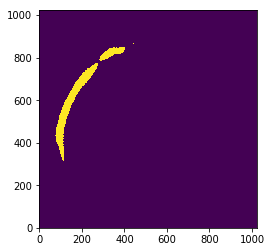

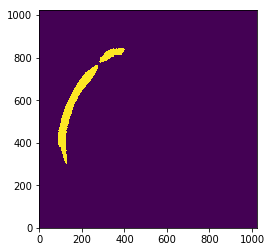

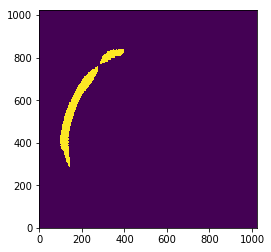

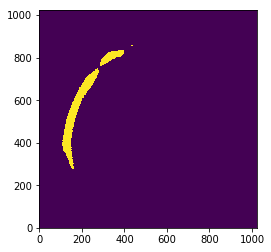

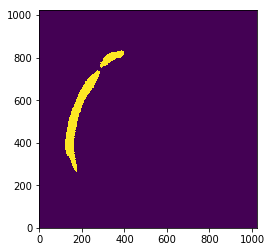

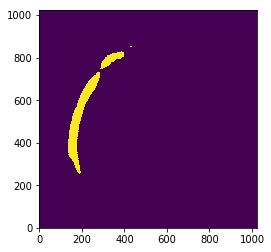

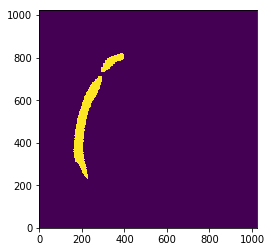

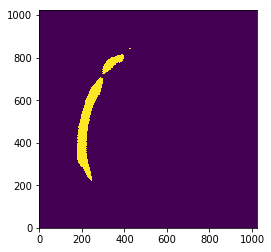

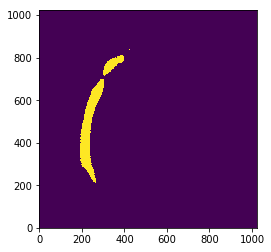

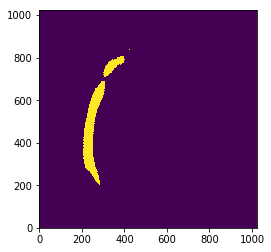

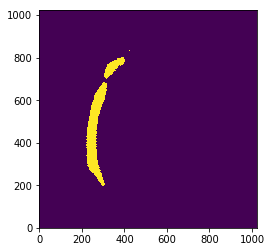

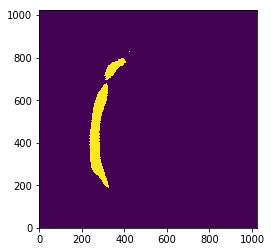

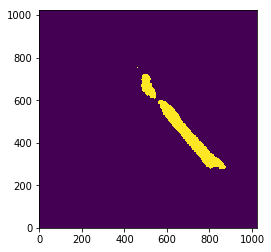

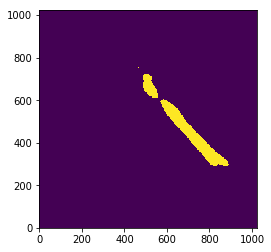

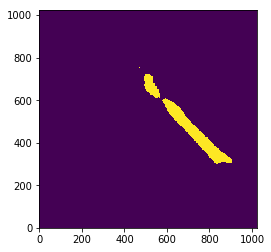

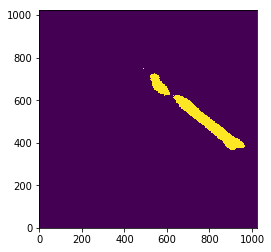

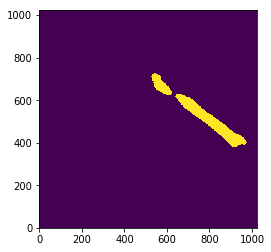

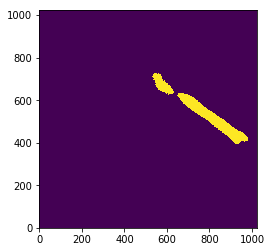

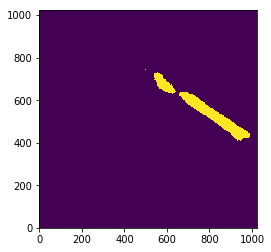

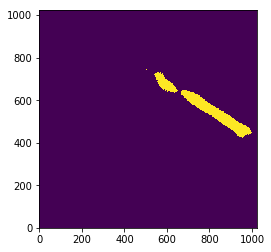

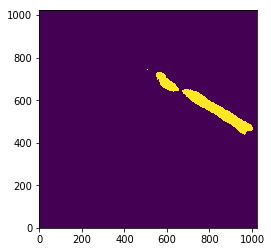

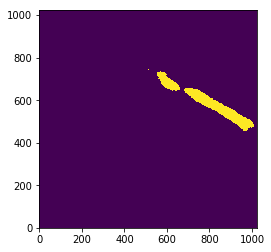

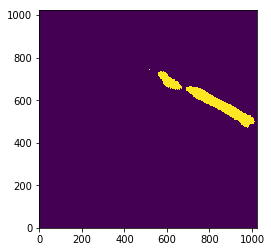

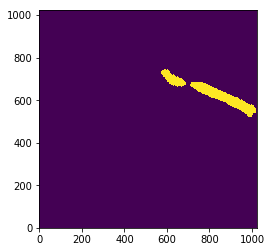

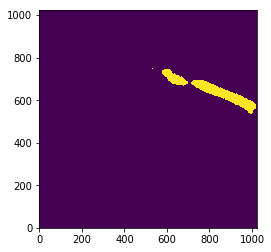

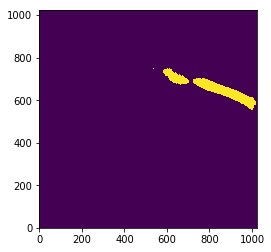

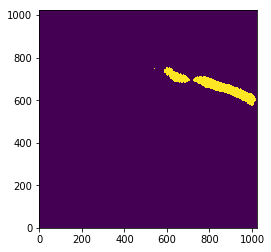

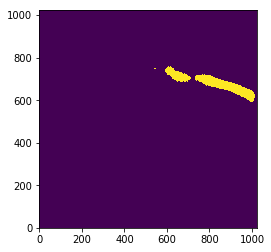

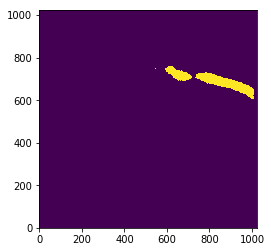

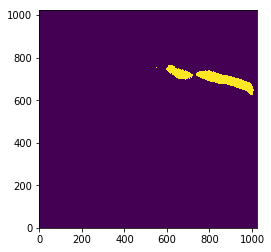

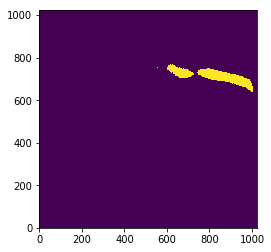

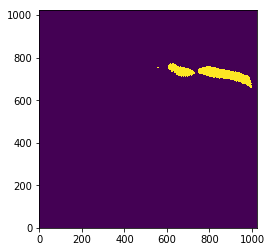

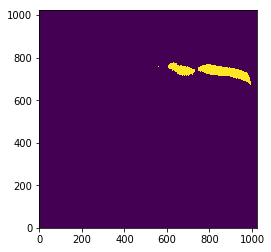

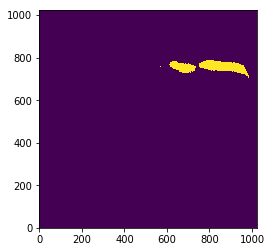

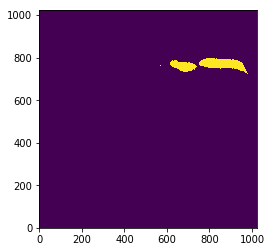

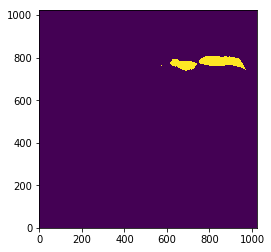

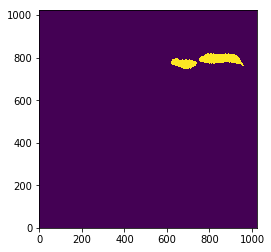

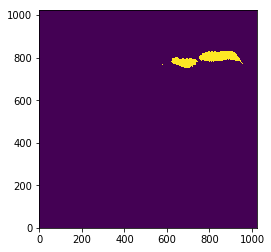

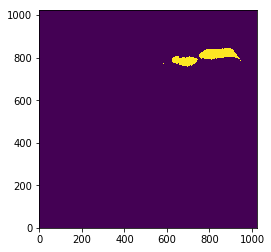

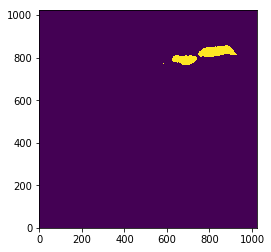

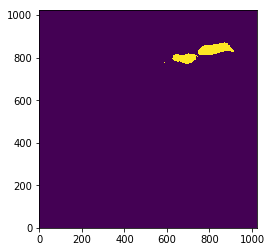

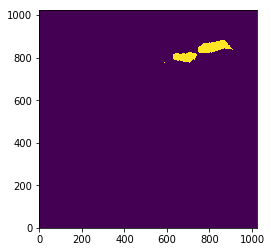

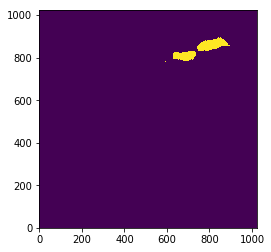

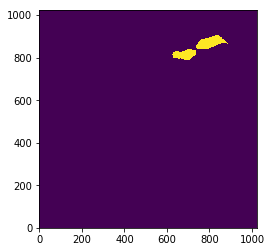

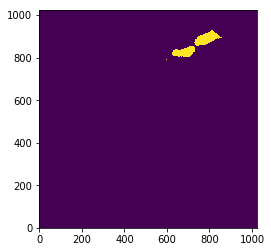

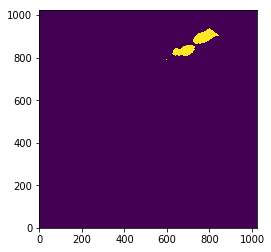

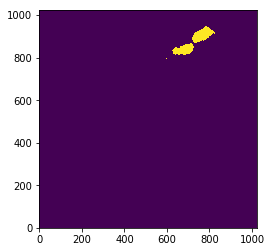

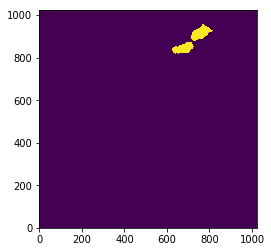

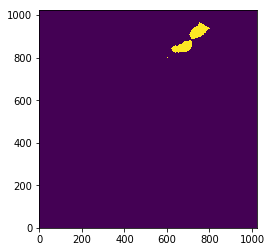

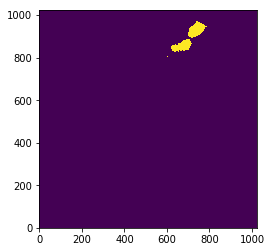

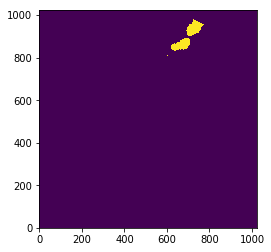

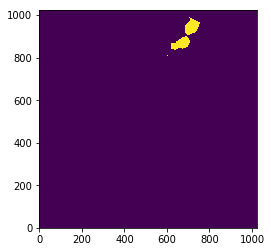

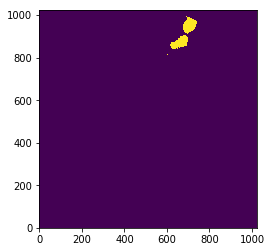

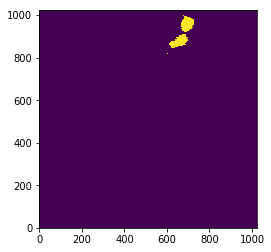

In [230]:

for _img in sorted(glob.glob("/data/20190408/2019-04-08T*:?0:27-S314-B8.fits")):

    plt.figure()
    meshx, meshy = np.meshgrid(np.linspace(0,1023,1024),np.linspace(0,1023,1024))
    image_wcs = WCS(_img)
    tmp_img = np.array(fits.open(_img)[0].data[0,0,:,:],dtype=np.float)

    ra,dec = hp.pixelfunc.pix2ang(nside, hp_index[mask != 0], lonlat=True)
    x, y, notused, nnotused = image_wcs.wcs_world2pix(ra,dec,1,1,1)

    img_contour = np.zeros([1023, 1023])

    img_contour[y[(np.abs(y - 512) < 512) & (np.abs(x - 512) < 512)].astype(int),
                x[(np.abs(y - 512) < 512) & (np.abs(x - 512) < 512)].astype(int)] = 1


    plt.imshow(img_contour, origin="lower")
    plt.show()